# M4-forecasting

## Libraries

In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import mxnet as mx
from mxnet import gluon
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.common import (
    FileDataset, ListDataset, TrainDatasets,
    CategoricalFeatureInfo, BasicFeatureInfo,
    MetaData,
)
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas
from gluonts.mx import (
    Trainer,
    SimpleFeedForwardEstimator,
    NBEATSEstimator, 
    NBEATSEnsembleEstimator,
    TemporalFusionTransformerEstimator,
    DeepAREstimator,
)
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.evaluation import make_evaluation_predictions

from pathlib import Path
from zipfile import ZipFile
import json

plt.rcParams["figure.figsize"] = (14, 4)
pd.options.display.max_columns = 99

## Parameters

In [350]:
root = "/home/ec2-user/projects/m4-forecasting"
unzip = False
session = "test_1"
dataset = "Monthly"
horizon = 18

## Constants

In [348]:
freq_alias = {
    "Yearly": "Y",
    "Quarterly": "Q",
    "Monthly": "M",
    "Weekly": "W",
    "Daily": "D",
    "Hourly": "H",
}

## Utils

In [ ]:
def save_model(path):
    path.mkdir(exist_ok=True)
    predictor_tft.serialize(path)
    print(f"Model saved to {path}")

## Set directories

In [6]:
root = Path(root)
data_dir = root / "data"
session_dir = data_dir / f"session/{session}"

data_dir.mkdir(exist_ok=True)
session_dir.mkdir(exist_ok=True, parents=True)

## Load

In [7]:
if unzip:
    with ZipFile(data_dir / "m4-forecasting.zip", 'r') as f:
        f.extractall(data_dir / "raw")

In [8]:
train_orig_df = pd.read_csv(data_dir / f"raw/{dataset}-train.csv")

In [9]:
m4_info = pd.read_csv(data_dir / f"raw/m4_info.csv")

In [10]:
train_orig_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,...,V2747,V2748,V2749,V2750,V2751,V2752,V2753,V2754,V2755,V2756,V2757,V2758,V2759,V2760,V2761,V2762,V2763,V2764,V2765,V2766,V2767,V2768,V2769,V2770,V2771,V2772,V2773,V2774,V2775,V2776,V2777,V2778,V2779,V2780,V2781,V2782,V2783,V2784,V2785,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
0,M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,5710.0,5260.0,5470.0,7870.0,7360.0,8470.0,7880.0,6750.0,6860.0,6220.0,6650.0,5450.0,5280.0,4970.0,5550.0,7750.0,7760.0,7190.0,7440.0,6590.0,6210.0,6010.0,6390.0,5780.0,5700.0,4680.0,4970.0,6850.0,6740.0,7490.0,6250.0,6900.0,5870.0,5610.0,6310.0,6110.0,6090.0,5810.0,6060.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,2650.0,2150.0,1910.0,2510.0,2100.0,1840.0,2330.0,1830.0,2290.0,2090.0,2340.0,2420.0,1850.0,1960.0,2000.0,2300.0,2160.0,1730.0,2090.0,1890.0,2180.0,1950.0,2020.0,1770.0,1960.0,1860.0,1340.0,2150.0,2180.0,2030.0,1730.0,1860.0,1880.0,2120.0,2140.0,2090.0,1890.0,1840.0,2130.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,2795.0,2796.0,2858.0,2782.0,2801.0,2907.0,2919.0,2937.0,2878.0,2841.0,2967.0,3050.0,2981.0,3076.0,3033.0,2936.0,2927.0,2929.0,2987.0,2777.0,2760.0,2769.0,2830.0,2861.0,2991.0,3063.0,3134.0,3020.0,2947.0,3026.0,3060.0,3008.0,2972.0,2955.0,3350.0,3445.0,3432.0,3447.0,3450.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,7014.0,7067.0,7099.0,7046.0,7139.0,7011.0,7022.0,7084.0,7036.0,7098.0,7083.0,7045.0,7057.0,6986.0,6937.0,6927.0,6953.0,7007.0,6949.0,6930.0,6925.0,6956.0,6946.0,6866.0,6814.0,6806.0,6806.0,6855.0,6951.0,6898.0,6898.0,6922.0,6768.0,6693.0,6656.0,6567.0,6663.0,6652.0,6714.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,4260.0,4180.0,4230.0,4270.0,4500.0,4410.0,4440.0,4430.0,4440.0,4540.0,4450.0,4420.0,4410.0,4300.0,4300.0,4420.0,4350.0,4340.0,4410.0,4340.0,4400.0,4360.0,4420.0,4470.0,4310.0,4280.0,4220.0,4190.0,4120.0,4150.0,4190.0,4180.0,4320.0,4190.0,4200.0,4320.0,4220.0,4290.0,4230.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,M47996,9964.0,7212.0,7858.0,8493.0,8203.0,8362.0,7238.0,7357.0,8642.0,8833.0,11009.0,12475.0,10416.0,7056.0,8365.0,9004.0,9888.0,9469.0,7868.0,7774.0,9062.0,9342.0,10767.0,11281.0,9052.0,7993.0,8742.0,8650.0,8478.0,8154.0,6827.0,6313.0,7228.0,8280.0,9580.0,10622.0,9985.0,6370.0,7657.0,7889.0,7587.0,7375.0,6440.0,6065.0,7631.0,7781.0,9235.0,11249.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [11]:
m4_info

,M4id,category,Frequency,Horizon,SP,StartingDate
0,Y1,Macro,1,6,Yearly,01-01-79 12:00
1,Y2,Macro,1,6,Yearly,01-01-79 12:00
2,Y3,Macro,1,6,Yearly,01-01-79 12:00
3,Y4,Macro,1,6,Yearly,01-01-79 12:00
4,Y5,Macro,1,6,Yearly,01-01-79 12:00
...,...,...,...,...,...,...
99995,H410,Other,24,48,Hourly,01-01-17 12:00
99996,H411,Other,24,48,Hourly,01-01-17 12:00
99997,H412,Other,24,48,Hourly,01-01-17 12:00
99998,H413,Other,24,48,Hourly,12-06-17 12:00


## Prepare

In [12]:
def remove_trailing_nan(df):
    df = df.set_index("t")
    df = df.loc[:df.y.last_valid_index()].reset_index()
    return df

In [13]:
def parse_dates(m4_info):
    dates = []

    match = m4_info.StartingDate.str.fullmatch(r"\d\d-\d\d-\d\d \d\d:\d\d")
    dates.append(pd.to_datetime(m4_info.loc[match, "StartingDate"], format="%d-%m-%y %H:%M"))

    match = m4_info.StartingDate.str.fullmatch(r"\d\d-\d\d-\d\d \d:\d\d")
    dates.append(pd.to_datetime(m4_info.loc[match, "StartingDate"], format="%d-%m-%y %H:%M"))

    match = m4_info.StartingDate.str.fullmatch(r"\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d")
    dates.append(pd.to_datetime(m4_info.loc[match, "StartingDate"], format="%Y-%m-%d %H:%M:%S"))

    dates = pd.concat(dates)
    dates[dates.dt.year > 2018] = dates[dates.dt.year > 2018] - pd.offsets.DateOffset(years=100)

    m4_info = m4_info.copy()
    m4_info["StartingDate"] = dates

    return m4_info

In [14]:
def add_date_col(df):
    df = df.copy()
    freq = df["SP"].iloc[0]

    start = df["StartingDate"].iloc[0]
    periods = len(df)
    try:
        dates = pd.date_range(start=start, periods=periods, freq=freq_alias[freq], normalize=True)
    except pd.errors.OutOfBoundsDatetime:
        dates = pd.DatetimeIndex([pd.NaT for _ in range(periods)])
    df["date"] = dates
    return df

In [15]:
def prepare_data(df, m4_info):
    m4_info = parse_dates(m4_info)
    df.columns = pd.Index(["unique_id"] + list(range(df.shape[1] - 1)))
    df = pd.melt(df, id_vars=["unique_id"], value_name="y", var_name="t")
    df["t"] = pd.to_numeric(df["t"])
    df = df.groupby("unique_id").apply(remove_trailing_nan).reset_index(drop=True)
    df = df.merge(m4_info, left_on="unique_id", right_on="M4id")
    df = df.groupby("unique_id", group_keys=False).apply(add_date_col)
    df = df[["unique_id", "date", "t", "y", "category"]]
    return df

In [16]:
train_df = prepare_data(train_orig_df, m4_info)

In [17]:
train_df.isna().sum()

unique_id    0
date         0
t            0
y            0
category     0
dtype: int64

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10382411 entries, 0 to 10382410
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   unique_id  object        
 1   date       datetime64[ns]
 2   t          int64         
 3   y          float64       
 4   category   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 475.3+ MB


In [19]:
filepath = session_dir / "train_df.csv"
train_df.to_csv(filepath, index=False)
print(f"Data written to {filepath}")

Data written to /home/ec2-user/projects/m4-forecasting/data/session/test_1/train_df.csv


## Sample

In [ ]:
# train_df = pd.read_csv(session_dir / "train_df.csv", parse_dates=["date"])

In [84]:
def sample(df, n):
    samples = np.random.choice(df.unique_id.unique(), n, replace=False)
    df = df[df.unique_id.isin(samples)].copy()
    return df

In [325]:
train_sample_df = sample(train_df, 1000)

In [326]:
train_sample_df

,unique_id,date,t,y,category
12893,M10044,1988-01-31,0,1000.000,Micro
12894,M10044,1988-02-29,1,1001.752,Micro
12895,M10044,1988-03-31,2,988.305,Micro
12896,M10044,1988-04-30,3,979.129,Micro
12897,M10044,1988-05-31,4,980.576,Micro
...,...,...,...,...,...
10378980,M9963,2015-05-31,64,1140.000,Macro
10378981,M9963,2015-06-30,65,1200.000,Macro
10378982,M9963,2015-07-31,66,1240.000,Macro
10378983,M9963,2015-08-31,67,1260.000,Macro


## Features

In [327]:
def prepare_features(df):
    df["y_scaled"] = df.groupby("unique_id", group_keys=False)["y"].apply(lambda x: (x - x.mean()) / x.std())
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["t"] = df["t"].astype("float32")
    df["unique_id"] = pd.factorize(df["unique_id"])[0]
    df["category"] = pd.factorize(df["category"])[0]
    return df

In [328]:
train_sample_df = prepare_features(train_sample_df)

In [329]:
# train_sample_df = pd.get_dummies(train_sample_df, columns=["month"])

In [330]:
train_sample_df

,unique_id,date,t,y,category,y_scaled,month,year
12893,0,1988-01-31,0.0,1000.000,0,-0.475291,1,1988
12894,0,1988-02-29,1.0,1001.752,0,-0.454107,2,1988
12895,0,1988-03-31,2.0,988.305,0,-0.616693,3,1988
12896,0,1988-04-30,3.0,979.129,0,-0.727638,4,1988
12897,0,1988-05-31,4.0,980.576,0,-0.710143,5,1988
...,...,...,...,...,...,...,...,...
10378980,999,2015-05-31,64.0,1140.000,1,-0.944040,5,2015
10378981,999,2015-06-30,65.0,1200.000,1,-0.866448,6,2015
10378982,999,2015-07-31,66.0,1240.000,1,-0.814720,7,2015
10378983,999,2015-08-31,67.0,1260.000,1,-0.788855,8,2015


## Train-test split

In [331]:
def train_test_split(df, horizon):
    train_df = df.groupby("unique_id", group_keys=False).apply(lambda x: x.iloc[:-horizon])
    test_df = df.copy()
    return train_df, test_df

In [332]:
train_sample_df, val_sample_df = train_test_split(train_sample_df, horizon)

<AxesSubplot: >

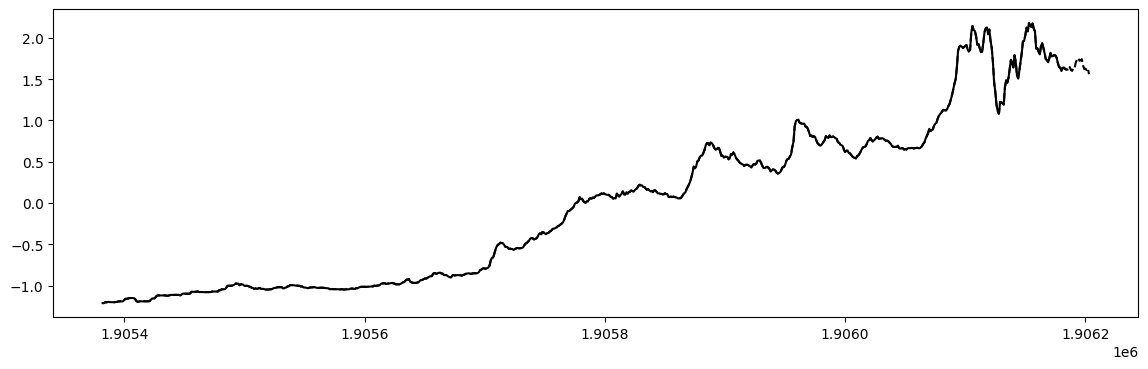

In [333]:
elem_id = train_sample_df.unique_id.sample(1).iloc[0]
y_train = train_sample_df.loc[train_sample_df.unique_id == elem_id, "y_scaled"]
y_val = val_sample_df.loc[val_sample_df.unique_id == elem_id, "y_scaled"]

y_train.plot(color="black")
y_val.plot(color="black", style="--")

## Model

### Temporal Fusion Transformer

In [410]:
def build_list_dataset_tft(dataset_df, freq):
    dataset_list = []
    for key in dataset_df.unique_id.unique():
        df = dataset_df[dataset_df.unique_id == key]
        entry = dict(
            start = pd.Period(df.date.iloc[0], freq=freq),
            target = df.y_scaled.to_numpy(),
            t = df.t.to_numpy().reshape(1, -1),
            unique_id = df.unique_id.head(1).to_numpy(),
            category = df.category.head(1).to_numpy(),
            month = df.month.to_numpy(),
            year = df.year.to_numpy(),
        )
        dataset_list.append(entry)
    dataset_tft = ListDataset(dataset_list, freq=freq)
    return dataset_tft

In [411]:
def build_metadata_tft(dataset_df, freq, horizon):
    cardinality_unique_id = len(dataset_df["unique_id"].unique())
    cardinality_year = len(dataset_df["year"].unique())

    metadata = MetaData(
        freq=freq_alias[dataset],
        feat_static_cat = [
            CategoricalFeatureInfo(name='unique_id', cardinality=cardinality_unique_id),
            CategoricalFeatureInfo(name='category', cardinality=6),
        ],
        feat_dynamic_real = [
            BasicFeatureInfo(name="t"),
        ],
        feat_dynamic_cat = [
            CategoricalFeatureInfo(name="year", cardinality=cardinality_year),
            CategoricalFeatureInfo(name="month", cardinality=12)
        ],
        prediction_length=horizon,
    )

    return metadata

In [412]:
def build_dataset_tft(train_df, val_df, freq, horizon):
    metadata = build_metadata_tft(train_df, freq=freq, horizon=horizon)
    dataset_train = build_list_dataset_tft(train_df, freq=metadata.freq)
    dataset_val = build_list_dataset_tft(val_df, freq=metadata.freq)
    dataset_full = TrainDatasets(metadata=metadata, train=dataset_train, test=dataset_val)
    return dataset_full

In [413]:
dataset_full = build_dataset_tft(train_sample_df, val_sample_df, freq_alias[dataset], horizon)

In [425]:
estimator_tft = TemporalFusionTransformerEstimator(
    trainer=Trainer(
        ctx=mx.gpu(0), 
        epochs=500, 
        learning_rate=1e-3, 
        num_batches_per_epoch=50,
        hybridize=False,
    ),
    batch_size=1024,
    freq=freq_alias[dataset],
    prediction_length=horizon,
    context_length=3*horizon,
    hidden_dim=32,
    static_cardinalities={
        feat.name: feat.cardinality for feat in dataset_full.metadata.feat_static_cat
    },
    dynamic_cardinalities={
        feat.name: feat.cardinality for feat in dataset_full.metadata.feat_dynamic_cat
    },
    dynamic_feature_dims={"t": 1}
)

In [426]:
predictor_tft = estimator_tft.train(dataset_full.train)

 16%|█▌        | 8/50 [00:04<00:23,  1.78it/s, epoch=433/500, avg_epoch_loss=0.0411]
/home/ec2-user/anaconda3/envs/gluonts/lib/python3.11/site-packages/gluonts/mx/trainer/_base.py:474: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(


In [427]:
save_model(session_dir / "tft")

Model saved to /home/ec2-user/projects/m4-forecasting/data/session/test_1/tft


In [429]:
#train_it = iter(dataset_train)
fcst_it, val_it = make_evaluation_predictions(
    dataset=dataset_full.test,
    predictor=predictor_tft,
    num_samples=100,
)

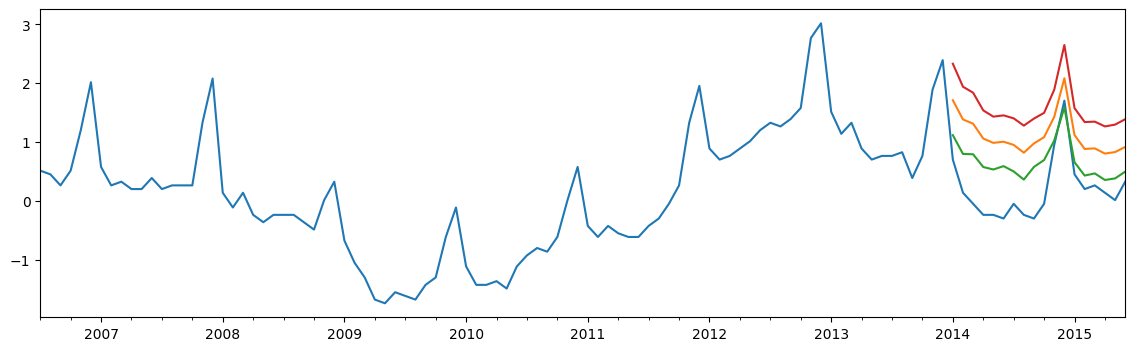

In [471]:
y_val = next(val_it)[0]
y_fcst = next(fcst_it)

y_val.tail(6*horizon).plot()
y_fcst.plot()

### DeepAR

In [649]:
dataset_train = PandasDataset.from_long_dataframe(
    train_df, 
    target="y_scaled",
    timestamp="date",
    item_id="unique_id",
    freq="M",
    feat_dynamic_real=[
        "t", "month_1", 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'
    ],
    feat_static_cat=["unique_id", "category"],
)

In [650]:
dataset_val = PandasDataset.from_long_dataframe(
    val_df, 
    target="y_scaled",
    timestamp="date",
    item_id="unique_id",
    freq="M",
    feat_dynamic_real=[
        "t", "month_1", 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
        'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'
    ],
    feat_static_cat=["unique_id", "category"],
)

In [664]:
train_df.category.unique()

array([0, 1, 2, 3, 4, 5])

In [662]:
len(train_df.unique_id.unique())

980

In [665]:
estimator_deepar = DeepAREstimator(
    trainer=Trainer(
        ctx=mx.gpu(), 
        epochs=100, 
        learning_rate=1e-3, 
        num_batches_per_epoch=50,
    ),
    freq=freq_alias[dataset], 
    prediction_length=horizon,
    context_length=3*horizon,
    use_feat_dynamic_real=True,
    use_feat_static_real=False,
    use_feat_static_cat=True,
    cardinality=[980, 6]
)

In [666]:
predictor_deepar = estimator_deepar.train(dataset_train)

100%|██████████| 50/50 [00:05<00:00,  9.68it/s, epoch=100/100, avg_epoch_loss=-.768]


In [667]:
predictor_deepar.serialize(session_dir)

In [668]:
train_it = iter(dataset_train)
fcst_it, val_it = make_evaluation_predictions(
    dataset=dataset_val,
    predictor=predictor_deepar,
    num_samples=100,
)

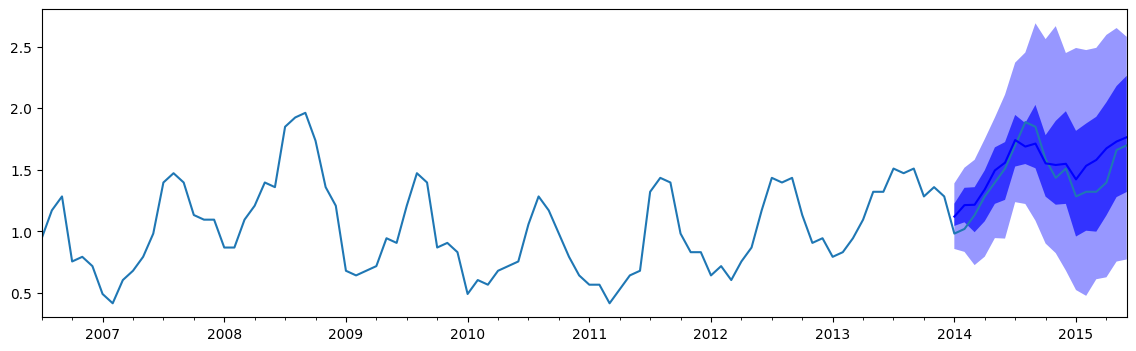

In [691]:
y_val = next(val_it)[0]
y_fcst = next(fcst_it)

y_val.tail(6*horizon).plot()
y_fcst.plot()

### NBEATS

In [244]:
estimator_nbeats = NBEATSEstimator(
    freq=freq_alias[dataset], 
    prediction_length=horizon,
    context_length=2*horizon,
    trainer=Trainer(
        ctx=mx.gpu(), 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100,
    ),
    num_stacks=2,
    widths=[256, 2048],
    num_blocks=[3],
    num_block_layers=[4],
    sharing=[True],
    expansion_coefficient_lengths=[3],
    stack_types=["T", "S"],
    loss_function="MAPE",
    batch_size=1024,
)

In [245]:
predictor_nbeats = estimator_nbeats.train(dataset_train)

100%|██████████| 100/100 [00:46<00:00,  2.15it/s, epoch=10/10, avg_epoch_loss=2.91e+7]


In [37]:
predictor_nbeats.serialize(session_dir)

In [ ]:
# predictor = Predictor.deserialize(session_dir)

In [246]:
train_it = iter(dataset_train)
fcst_it, val_it = make_evaluation_predictions(
    dataset=dataset_val,
    predictor=predictor_nbeats,
    num_samples=1,
)

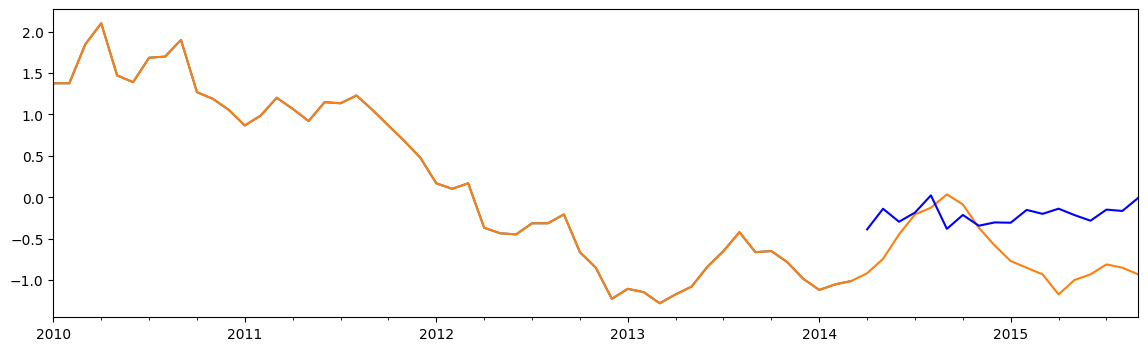

In [262]:
y_train = to_pandas(next(train_it))
y_val = next(val_it)[0]
y_fcst = next(fcst_it)

y_train.plot()
y_val.plot()
y_fcst.plot()

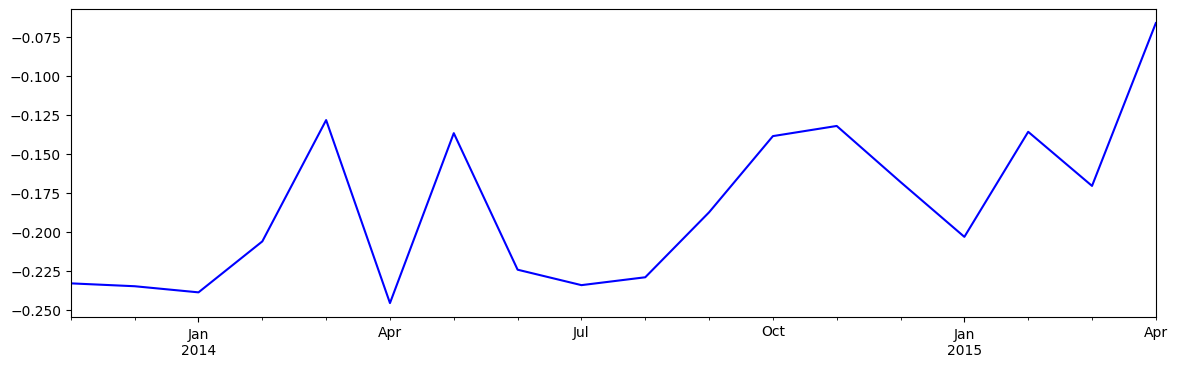

In [295]:
y_fcst = next(fcst_it)
y_fcst.plot()

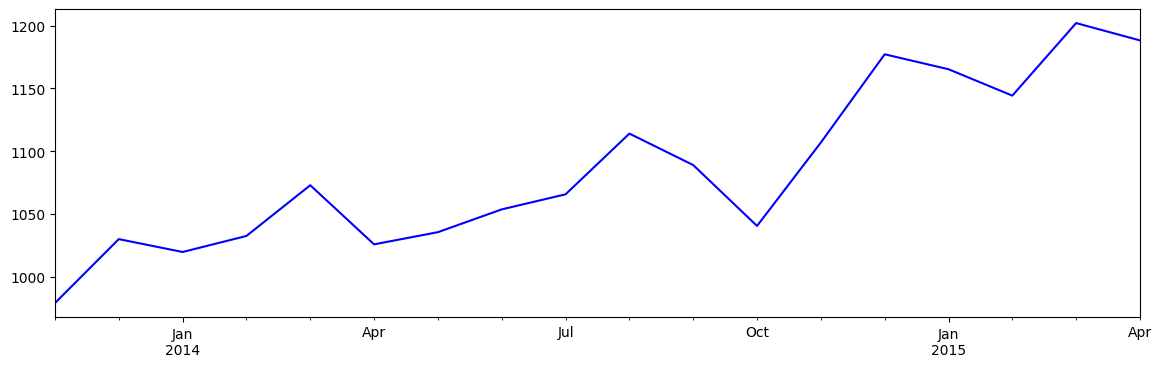

In [136]:
y_fcst = next(fcst_it)
y_fcst.plot()

In [111]:
y_fcst

gluonts.model.forecast.SampleForecast(info=None, item_id="M10001", samples=numpy.array([[978.8731689453125, 1029.8421630859375, 1019.5772094726562, 1032.3592529296875, 1072.777099609375, 1025.678466796875, 1035.3741455078125, 1053.544921875, 1065.54296875, 1113.9326171875, 1088.86865234375, 1040.356689453125, 1106.81201171875, 1177.1373291015625, 1165.2138671875, 1144.194580078125, 1202.0035400390625, 1188.192138671875]], numpy.dtype("float32")), start_date=pandas.Timestamp("2014-04", freq="M"))

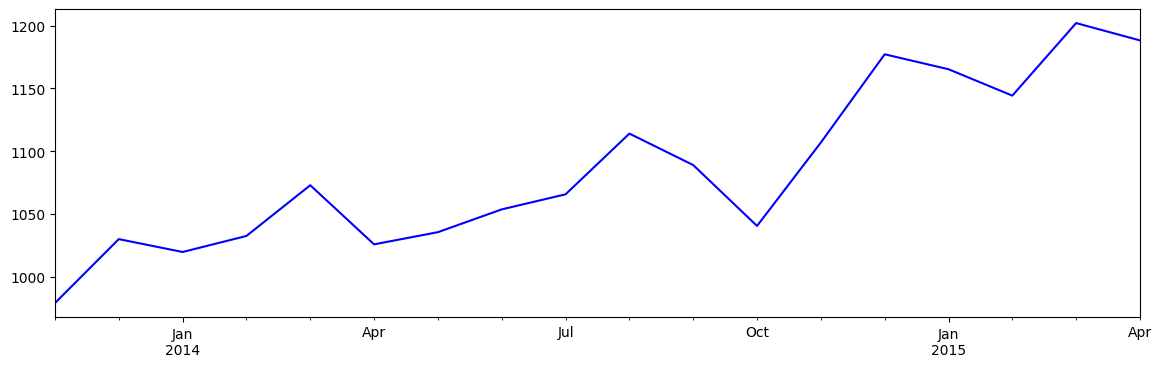

In [132]:
y_fcst = next(fcst_it)
y_fcst.plot()